# Final Project - CIFAR-10 Image Classification

Nitzan Ron ID 215451709, Adam Zelzer ID 328489166

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 7

## About the Dataset

The CIFAR-10 dataset consists of 60000 `32x32` color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

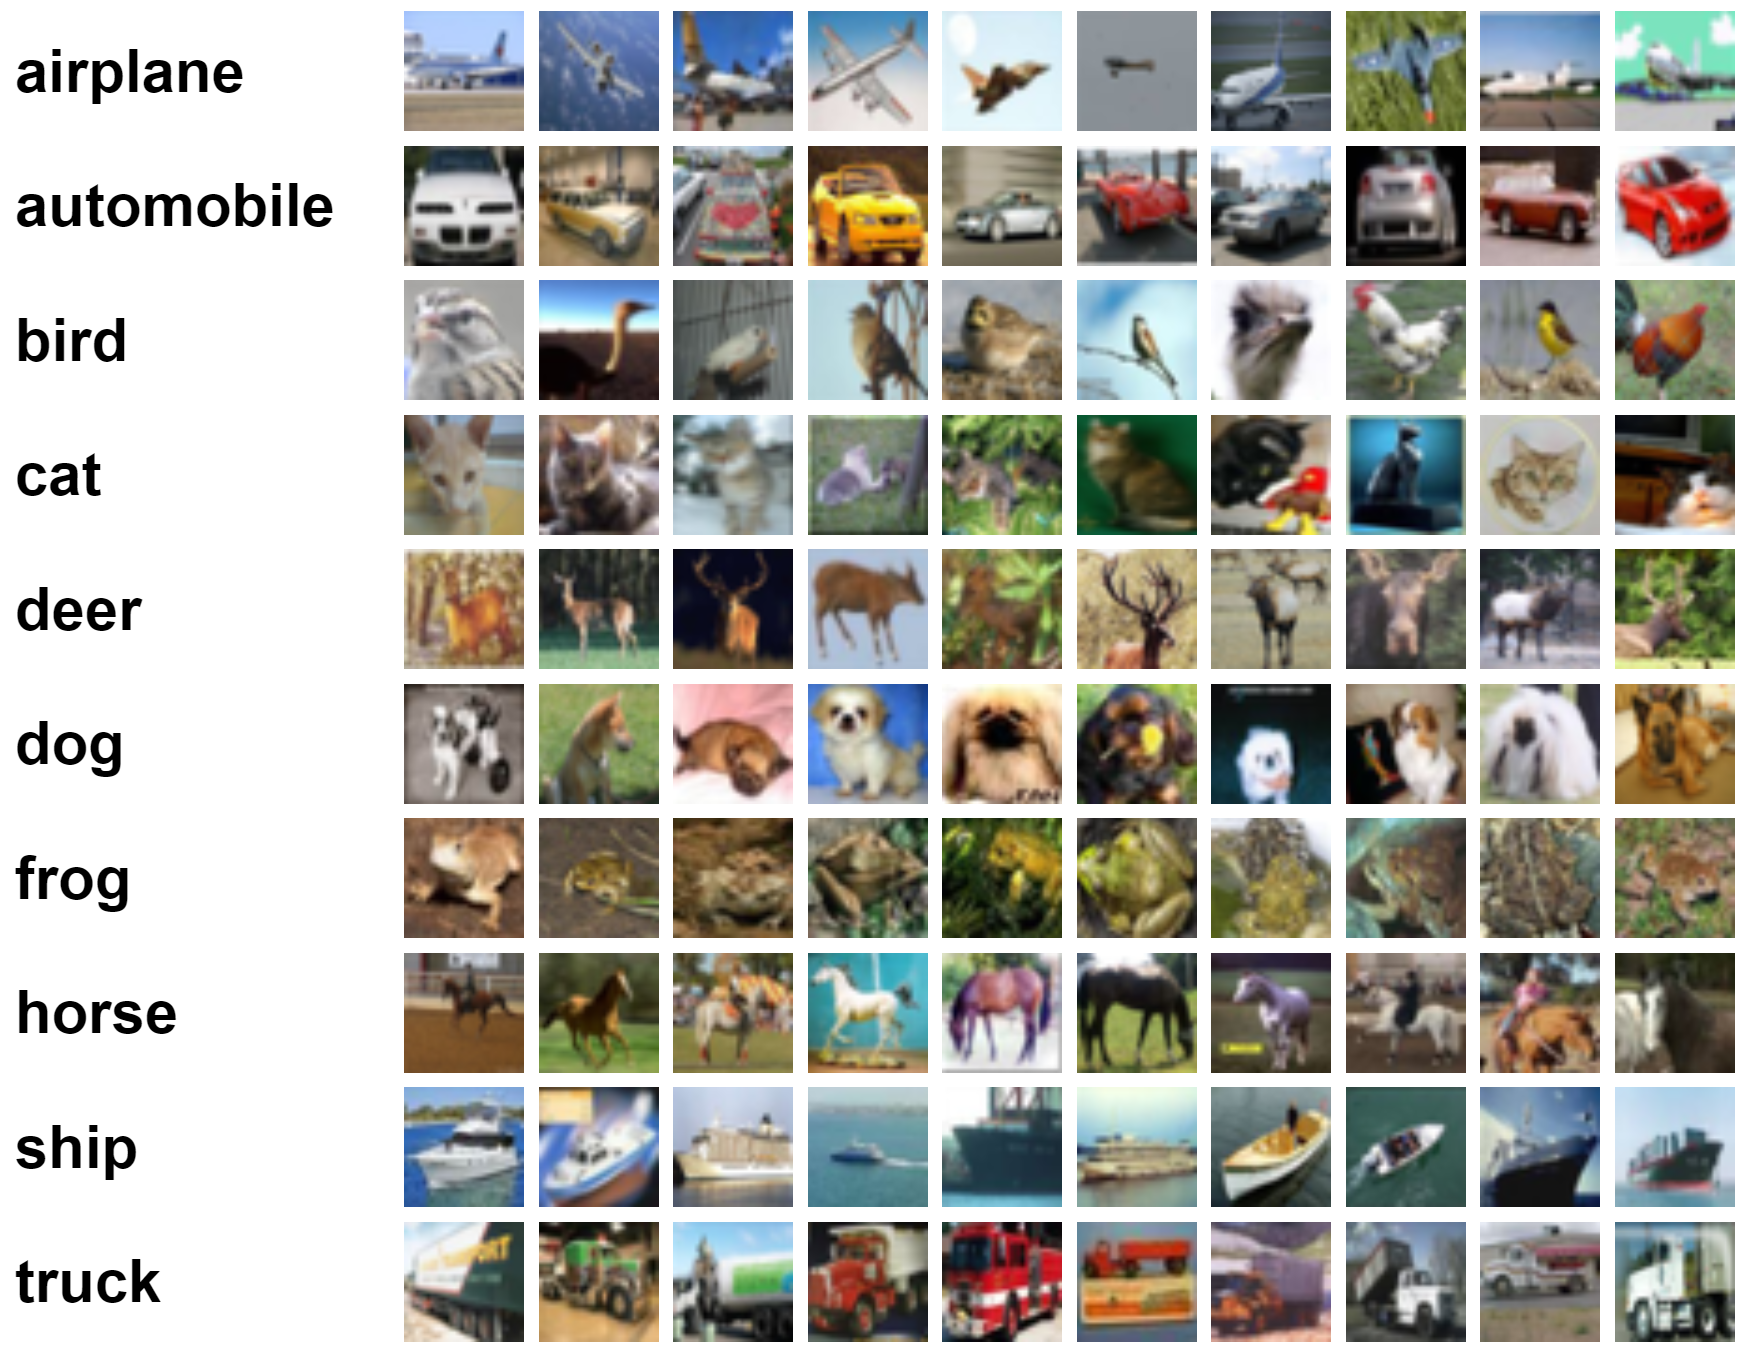

In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

We can plot some of the images:

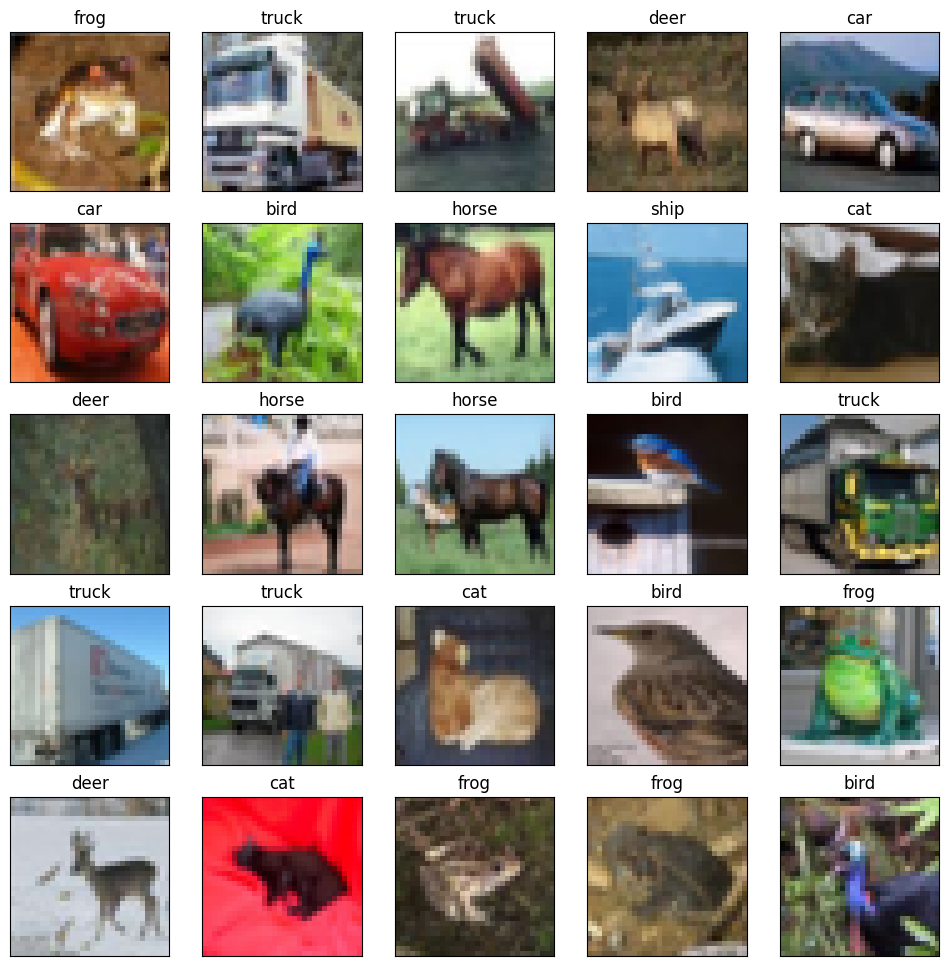

In [5]:
fig  = plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.title(classes[y_train[i][0]])

## Preprocessing and Dimensionality Reduction

Before we try the CNN approach, we would like to utilize the standard out-of-the-box models that `sklearn` has to offer. To do that, the images must be flattened, and their dimension, which is currently `3072`, must be reduced. Here we try a couple of dimensionality-reduction techniques.

In [6]:
def reshape(X):
  return X.reshape(X.shape[0], -1)

x_train_flat = reshape(x_train)
x_test_flat = reshape(x_test)

y_train = y_train.flatten()
y_test = y_test.flatten()

In [7]:
assert (x_train_flat.shape == (50000, 3072))
assert (x_test_flat.shape == (10000, 3072))

### Canny Edge Detection

This is an image processing technique, used to detect edges in a picture. This may help, as it reduces each picture to a binary array of size `1024`.

In [11]:
import cv2
def canny_edge_detection(X):
  X_canny = []
  for i in range(X.shape[0]):
    img = cv2.cvtColor(X[i], cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.Canny(img, 80, 160)
    X_canny.append(img)
  return np.array(X_canny)

In [12]:
x_train_edge = canny_edge_detection(x_train)
x_test_edge = canny_edge_detection(x_test)

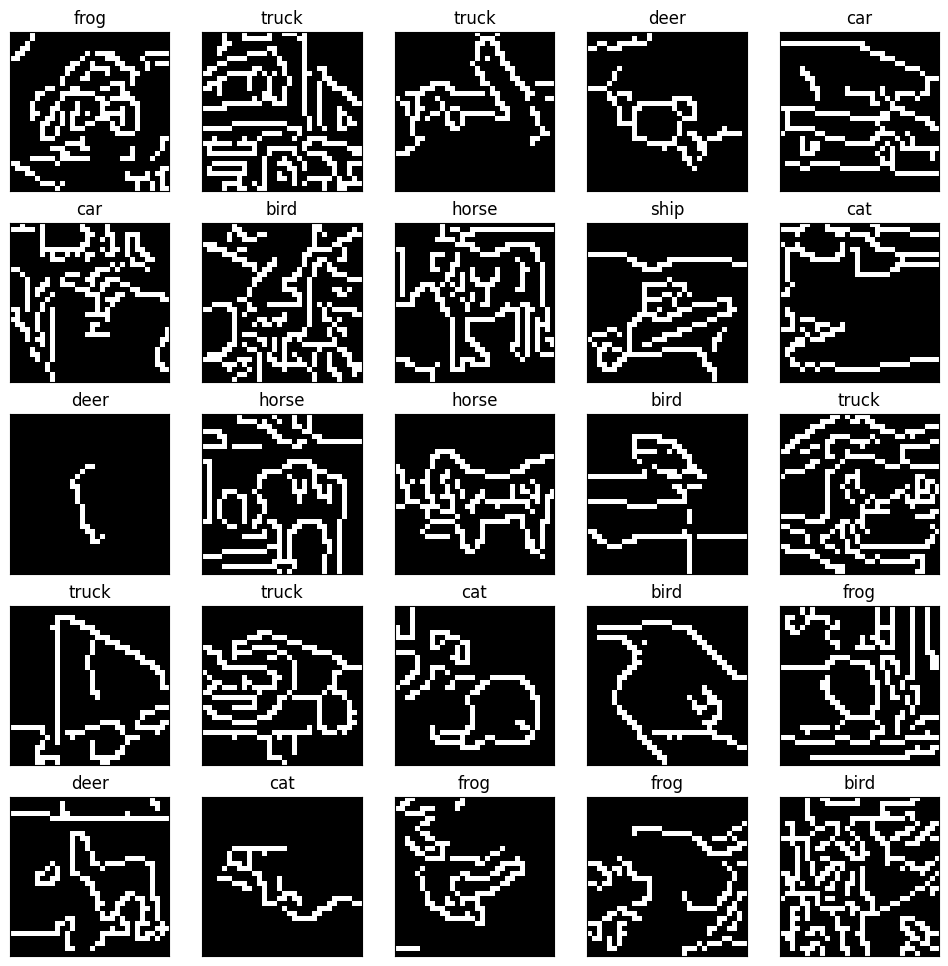

In [13]:
fig  = plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_edge[i], cmap='gray')
    plt.title(classes[y_train[i]])

Since the images are really low quality (`32x32`), the results are mixed. Some images look good, while others are a complete mess. This will make it harder for our models to distinguish between the classes.

### Dominant Colors

We will use the technique of extracting dominant colors in the image in order to try to classify images. We can see from the images in *Cifar-10* dataset that each type of image has dominant colors with which we can classify it correctly. We will use `3` dominant colors.

In [14]:
from sklearn.cluster import KMeans

In [15]:
def dominant_colors_per_image(image):
  # Get the dimensions (width, height, and depth) of the image
  w, h, d = tuple(image.shape)

  # Reshape the image into a 2D array, where each row represents a pixel
  pixels = np.reshape(image, (w * h, d))

  # Set the desired number of colors for the image
  n_colors = 3

  # Create a KMeans model with the specified number of clusters and fit it to the pixels
  model = KMeans(n_clusters=n_colors, random_state=seed)

  # Fit the model to the pixel data
  model.fit(pixels)

  # Get the cluster centers (representing colors) from the model
  color_palette = np.uint8(model.cluster_centers_)
  return color_palette

In [16]:
def dominant_colors(X):
  X_dominant_colors = []
  for i in range(X.shape[0]):
    X_dominant_colors.append(dominant_colors_per_image(X[i]))
  return np.array(X_dominant_colors)

In [17]:
x_train_dominant_colors = dominant_colors(x_train)
x_test_dominant_colors = dominant_colors(x_test)

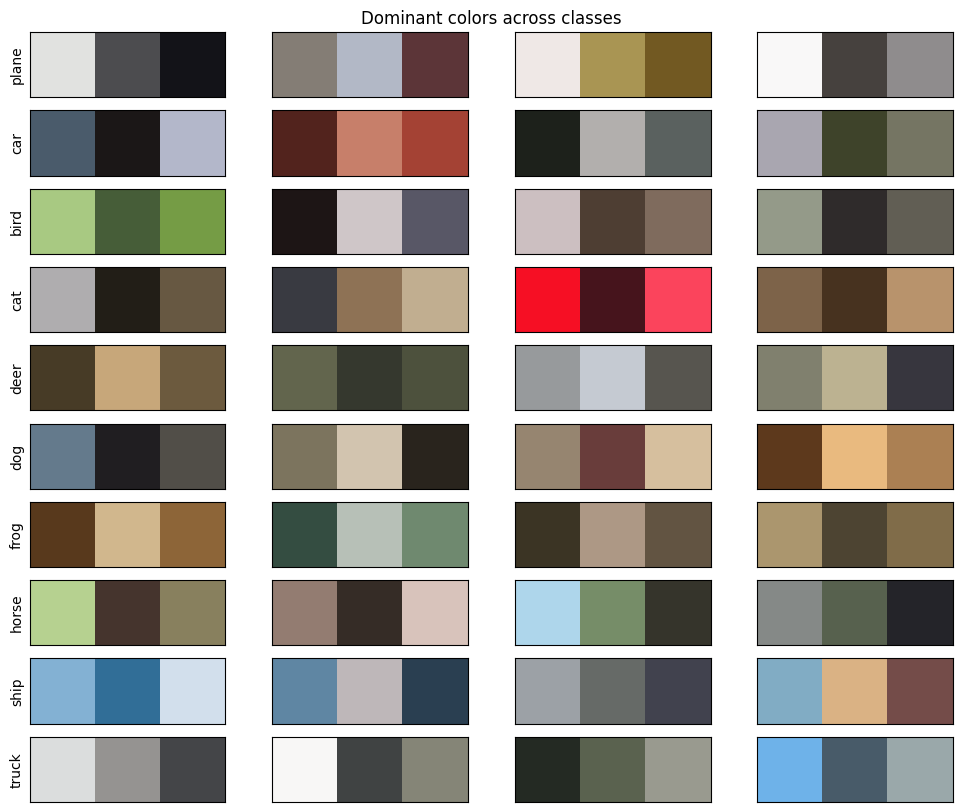

In [47]:
def plot_dominant_colors(X, y, classes):
    plt.figure(figsize=(12,10))
    plt.title("Dominant colors across classes")
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    for i in range(len(classes)):
        class_i_index = np.where(y==i)
        for j in range(4):
            plt.subplot(10,4,4*i+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow([X[class_i_index][j]])
            if j == 0:
                plt.ylabel(classes[i])
    

plot_dominant_colors(x_train_dominant_colors, y_train, classes)

We can see some difference between the classes (the blues in the `ship` row for example), but this probably won't be enough to differentiate between classes well.

### PCA

The classic way to reduce dimesionality.

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca(X, n_components):
  X = StandardScaler().fit_transform(X)
  pca = PCA(n_components=n_components, random_state=seed)
  X_transformed = pca.fit_transform(X)
  return X_transformed, pca

In [49]:
n_components = 100

# Apply PCA
x_train_pca, train_pca = apply_pca(x_train_flat, n_components)
x_test_pca, test_pca = apply_pca(x_test_flat, n_components)

We can look at the relative explained variance per feature to gain insight into the cutoff point. We can also use the elbow of the cumulative variance functionas a stopping point.

In [50]:
explained_variance = train_pca.explained_variance_ratio_
cummulative_variance = explained_variance.cumsum()
index = range(len(explained_variance))

In [51]:
from kneed import KneeLocator
kn = KneeLocator(index, explained_variance.cumsum(), curve='concave', direction='increasing')
elbow = kn.elbow
print(elbow)

19


Let us look at the graphs:

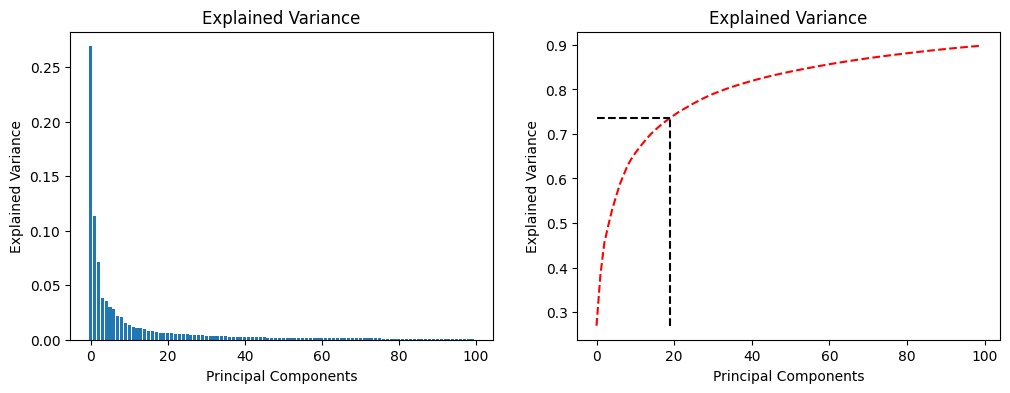

In [52]:
# Explained variance
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.bar(index, explained_variance)
plt.title('Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')

# Cumulative explained variance
plt.subplot(1,2,2)
plt.plot(index, cummulative_variance,'r--')
plt.vlines(x=elbow, ymin=cummulative_variance[0], ymax=cummulative_variance[elbow], color='k', linestyle='--')
plt.hlines(y=cummulative_variance[elbow], xmin=0, xmax=elbow, color='k', linestyle='--')
plt.title('Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.show()

The curve seems to flatten around `n_components = 40`, so we'll cut at 40 components. We can also look at the first 2 components to see if there are some patterns:

In [53]:
n_components = 40
x_train_reduced = x_train_pca[:,:n_components]
x_test_reduced = x_test_pca[:,:n_components]

In [54]:
# Creating dataframe for easier plotting
plot_df = pd.DataFrame(data = x_train_pca[:,:2], columns = ["PC 1", "PC 2"])
labels = [classes[y_i] for y_i in y_train]
plot_df["class"] = pd.Series(labels)

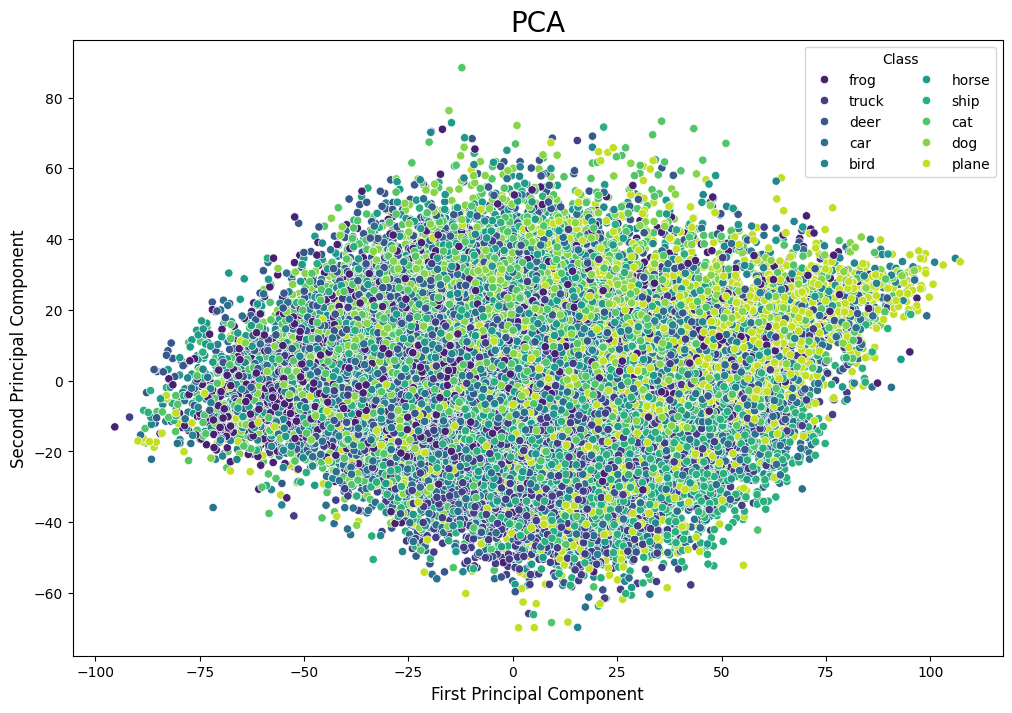

In [55]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)

sns.scatterplot(data=plot_df, x="PC 1", y="PC 2", hue="class", palette="viridis", legend = "full")

ax.legend(title="Class", fontsize='10', ncol=2)
ax.set_title('PCA', fontsize="20")
ax.set_xlabel('First Principal Component', fontsize='12')
ax.set_ylabel('Second Principal Component', fontsize='12')
plt.show()

Not a lot of patterns here, but we can see some clusters of images.

## Train Models

We'll use a couple standard models to classify the images.

In [56]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [57]:
# Define models

logreg_clf = LogisticRegression(random_state=seed, solver="saga")

percep_clf = Perceptron(random_state=seed)

tree_clf = DecisionTreeClassifier(random_state=seed)

forest_clf = RandomForestClassifier(random_state=seed)

ada_clf = AdaBoostClassifier(random_state=seed, algorithm="SAMME")

xgb_clf = XGBClassifier(random_state=seed)

knn_clf = KNeighborsClassifier()

In [58]:
models = {
    "Logistic Regression": logreg_clf,
    "Perceptron": percep_clf,
    "Decision Tree": tree_clf,
    "KNN": knn_clf,
    "Random Forest": forest_clf,
    "Adaboost": ada_clf,
    "XGBoost": xgb_clf,
}

We'll perform cross validation to select the 3 highest-scoring models, on which we'll perform hyperparameter tuning.

In [59]:
from sklearn.model_selection import cross_val_score
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    cv_scores = cross_val_score(model, x_train_reduced, y_train, cv=5, scoring='accuracy', verbose=3)
    print(f"{model_name} CV Accuracy:\t {cv_scores}")
    results[model_name] = cv_scores

Training Logistic Regression...
[CV] END ................................ score: (test=0.374) total time=   3.9s
[CV] END ................................ score: (test=0.362) total time=   3.7s
[CV] END ................................ score: (test=0.382) total time=   4.0s
[CV] END ................................ score: (test=0.369) total time=   3.6s
[CV] END ................................ score: (test=0.365) total time=   3.5s
Logistic Regression CV Accuracy:	 [0.3745 0.3622 0.3816 0.3688 0.365 ]
Training Perceptron...
[CV] END ................................ score: (test=0.191) total time=   0.9s
[CV] END ................................ score: (test=0.206) total time=   0.8s
[CV] END ................................ score: (test=0.196) total time=   0.8s
[CV] END ................................ score: (test=0.234) total time=   0.9s
[CV] END ................................ score: (test=0.201) total time=   0.8s
Perceptron CV Accuracy:	 [0.1912 0.2062 0.1957 0.2338 0.201 ]
Tr

In [61]:
# Calculate mean accuracies for all models
means = []
stds = []
for scores in results.values():
    means.append(np.mean(scores))
    stds.append(np.std(scores))

results_dict = {"model": models.keys(), "mean accuracy": means, "st. dev. of accuracy": stds}
results_df = pd.DataFrame(data=results_dict).sort_values(by="mean accuracy", axis=0, ascending=False).reset_index(drop=True)

In [62]:
results_df

model  mean accuracy  st. dev. of accuracy
0              XGBoost        0.48438              0.004145
1        Random Forest        0.46152              0.005196
2                  KNN        0.39122              0.007715
3  Logistic Regression        0.37042              0.006946
4        Decision Tree        0.27476              0.002594
5             Adaboost        0.26326              0.010164
6           Perceptron        0.20558              0.014981

**Key insight:** none of these results are good!

Which is what we expected, since we reduced each imaage from 3072 components down to 40, and we did it in linearly, which usually is not the best for images. Still, we'll try to improve performence.

## Hyperparameter Tuning

We'll look at the best performing models, and try to tune them so that the can perform better.

In [63]:
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### XGBoost

XGBoost, which is short for e**X**treme **G**radient **Boost**ing, in a gradient boosting algorithm, which uses an ensemble of unique decision trees to build a classifier.
It has many hyper-parameters, like tree depth, regularization coefficients, and number of trees.

In [64]:
xgb_param_grid = {
        "n_estimators": [100, 200, 400],
        "eta": [0.1, 0.25, 0.5],
        "max_depth": [5, 6, 7],
        "min_child_weight": [1, 3, 5],
        "lambda": [0.1, 0.5, 1],
        "alpha": [0.1, 0.5, 1],
        "gamma": [0.1, 0.5, 1],
        'subsample': [0.5, 0.75, 1.0],
        "random_state": [seed]
}

xgb_random_search = RandomizedSearchCV(xgb_clf, xgb_param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=3, random_state=seed)
_ = xgb_random_search.fit(x_train_reduced, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END alpha=0.5, eta=0.5, gamma=1, lambda=0.5, max_depth=7, min_child_weight=1, n_estimators=200, random_state=7, subsample=1.0;, score=(train=0.912, test=0.456) total time=  18.2s
[CV 2/3] END alpha=0.5, eta=0.5, gamma=1, lambda=0.5, max_depth=7, min_child_weight=1, n_estimators=200, random_state=7, subsample=1.0;, score=(train=0.909, test=0.452) total time=  25.8s
[CV 3/3] END alpha=0.5, eta=0.5, gamma=1, lambda=0.5, max_depth=7, min_child_weight=1, n_estimators=200, random_state=7, subsample=1.0;, score=(train=0.911, test=0.457) total time=  30.8s
[CV 1/3] END alpha=0.1, eta=0.25, gamma=1, lambda=0.1, max_depth=5, min_child_weight=1, n_estimators=200, random_state=7, subsample=1.0;, score=(train=0.790, test=0.475) total time=  24.9s
[CV 2/3] END alpha=0.1, eta=0.25, gamma=1, lambda=0.1, max_depth=5, min_child_weight=1, n_estimators=200, random_state=7, subsample=1.0;, score=(train=0.788, test=0.475) total time=  28.

In [81]:
print(f'''
Best params: {xgb_random_search.best_params_}
Best Cross-Validation Score: {xgb_random_search.best_score_:.2f}
''')


Best params: {'subsample': 0.5, 'random_state': 7, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 6, 'lambda': 0.1, 'gamma': 1, 'eta': 0.1, 'alpha': 0.1}
Best Cross-Validation Score: 0.50



In [66]:
# Save the best model
joblib.dump(xgb_random_search.best_estimator_, 'ootb_models\xgboost_best_model.joblib')

['xgboost_best_model.joblib']

### Random Forest

This is also an ensemble method, which uses a forest of decision trees, each trained on a random subsample of the training set, with random features selected to be used as criteria.

In [67]:
forest_param_grid = {
        "n_estimators": [100, 200, 400],
        "min_samples_leaf": [2, 5, 10],
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 4, 5],
        "random_state": [seed]
    }


forest_random_search = RandomizedSearchCV(forest_clf, forest_param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=3, random_state=seed)
_ = forest_random_search.fit(x_train_reduced, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END criterion=gini, max_depth=5, min_samples_leaf=5, n_estimators=200, random_state=7;, score=(train=0.377, test=0.357) total time=  52.5s
[CV 2/3] END criterion=gini, max_depth=5, min_samples_leaf=5, n_estimators=200, random_state=7;, score=(train=0.376, test=0.357) total time=  57.6s
[CV 3/3] END criterion=gini, max_depth=5, min_samples_leaf=5, n_estimators=200, random_state=7;, score=(train=0.377, test=0.351) total time=  46.6s
[CV 1/3] END criterion=entropy, max_depth=3, min_samples_leaf=2, n_estimators=100, random_state=7;, score=(train=0.327, test=0.323) total time=  45.8s
[CV 2/3] END criterion=entropy, max_depth=3, min_samples_leaf=2, n_estimators=100, random_state=7;, score=(train=0.330, test=0.324) total time=  45.9s
[CV 3/3] END criterion=entropy, max_depth=3, min_samples_leaf=2, n_estimators=100, random_state=7;, score=(train=0.325, test=0.314) total time=  39.4s
[CV 1/3] END criterion=entropy, max_depth=

In [80]:
print(f'''
Best params: {forest_random_search.best_params_}
Best Cross-Validation Score: {forest_random_search.best_score_:.2f}
''')


Best params: {'random_state': 7, 'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'gini'}
Best Cross-Validation Score: 0.35



We got the best result from the first model, without hyperparameter optimization. We'll save it

In [71]:
# Save the best model
joblib.dump(forest_clf, 'ootb_models\random_forest_best_model.joblib')

['random_forest_best_model.joblib']

### KNN

The most naive machine learnig algorithm, based on the assumption that close samples must belong to a similar class. Classifies a new sample based on the majority class of it k nearest neighbors in the dataset.

In [73]:
knn_param_grid = {
        "n_neighbors": [5, 7, 9],
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    }

knn_random_search = RandomizedSearchCV(knn_clf, knn_param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=3, random_state=seed)
knn_random_search.fit(x_train_reduced, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END n_neighbors=7, p=2, weights=distance;, score=(train=1.000, test=0.411) total time=   1.5s
[CV 2/3] END n_neighbors=7, p=2, weights=distance;, score=(train=1.000, test=0.402) total time=   1.4s
[CV 3/3] END n_neighbors=7, p=2, weights=distance;, score=(train=1.000, test=0.401) total time=   1.3s
[CV 1/3] END n_neighbors=9, p=2, weights=uniform;, score=(train=0.513, test=0.396) total time=   1.4s
[CV 2/3] END n_neighbors=9, p=2, weights=uniform;, score=(train=0.510, test=0.387) total time=   1.6s
[CV 3/3] END n_neighbors=9, p=2, weights=uniform;, score=(train=0.514, test=0.390) total time=   1.5s
[CV 1/3] END n_neighbors=5, p=2, weights=uniform;, score=(train=0.570, test=0.388) total time=   1.6s
[CV 2/3] END n_neighbors=5, p=2, weights=uniform;, score=(train=0.565, test=0.384) total time=   1.3s
[CV 3/3] END n_neighbors=5, p=2, weights=uniform;, score=(train=0.569, test=0.379) total time=   1.2s
[CV 1/3] END n_nei

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': [5, 7, 9], 'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=7, return_train_score=True, scoring='accuracy',
                   verbose=3)

In [79]:
print(f'''
Best params: {knn_random_search.best_params_}
Best Cross-Validation Score: {knn_random_search.best_score_:.2f}
''')


Best params: {'weights': 'distance', 'p': 2, 'n_neighbors': 9}
Best Cross-Validation Score: 0.41



In [75]:
# Save the best model
joblib.dump(knn_random_search.best_estimator_, 'ootb_models\knn_best_model.joblib')

['knn_best_model.joblib']

### Logistic Regression

The classic: uses a linear combination of the features, along with the `softmax` function, to classify samples.

In [76]:
log_reg_param_grid = {
        "penalty": ['l1', 'l2'],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "solver": ['saga'],
        'max_iter': [100, 200, 500],
        "random_state": [seed]
  }


logreg_random_search = RandomizedSearchCV(logreg_clf, log_reg_param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=3, random_state=seed)
_ = logreg_random_search.fit(x_train_reduced, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=100, max_iter=200, penalty=l1, random_state=7, solver=saga;, score=(train=0.374, test=0.370) total time=   5.4s
[CV 2/3] END C=100, max_iter=200, penalty=l1, random_state=7, solver=saga;, score=(train=0.372, test=0.374) total time=   5.4s
[CV 3/3] END C=100, max_iter=200, penalty=l1, random_state=7, solver=saga;, score=(train=0.377, test=0.367) total time=   5.4s
[CV 1/3] END C=0.001, max_iter=200, penalty=l1, random_state=7, solver=saga;, score=(train=0.365, test=0.359) total time=   4.1s
[CV 2/3] END C=0.001, max_iter=200, penalty=l1, random_state=7, solver=saga;, score=(train=0.363, test=0.366) total time=   4.3s
[CV 3/3] END C=0.001, max_iter=200, penalty=l1, random_state=7, solver=saga;, score=(train=0.367, test=0.363) total time=   4.1s
[CV 1/3] END C=10, max_iter=100, penalty=l1, random_state=7, solver=saga;, score=(train=0.374, test=0.370) total time=   5.2s
[CV 2/3] END C=10, max_iter=100, penalty=l1, 

In [78]:
print(f'''
Best params: {logreg_random_search.best_params_}
Best Cross-Validation Score: {logreg_random_search.best_score_:.2f}
''')


Best params: {'solver': 'saga', 'random_state': 7, 'penalty': 'l2', 'max_iter': 100, 'C': 0.001}
Best Cross-Validation Score: 0.37



In [82]:
# Save the best model
joblib.dump(logreg_random_search.best_estimator_, 'ootb_models\logistic_regression_best_model.joblib')

['logistic_regression_best_model.joblib']

## Model Evaluation

The best performing model was XGBoost. Now, we can evaluate its performance on the test set.

In [99]:
best_model = joblib.load("ootb_models\xgboost_best_model.joblib")

# Fit model
best_model.fit(x_train_reduced, y_train)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400, ...)

In [103]:
y_proba = best_model.predict_proba(x_test_reduced)
y_pred = np.argmax(y_proba, axis=1)

### Confusion matrix

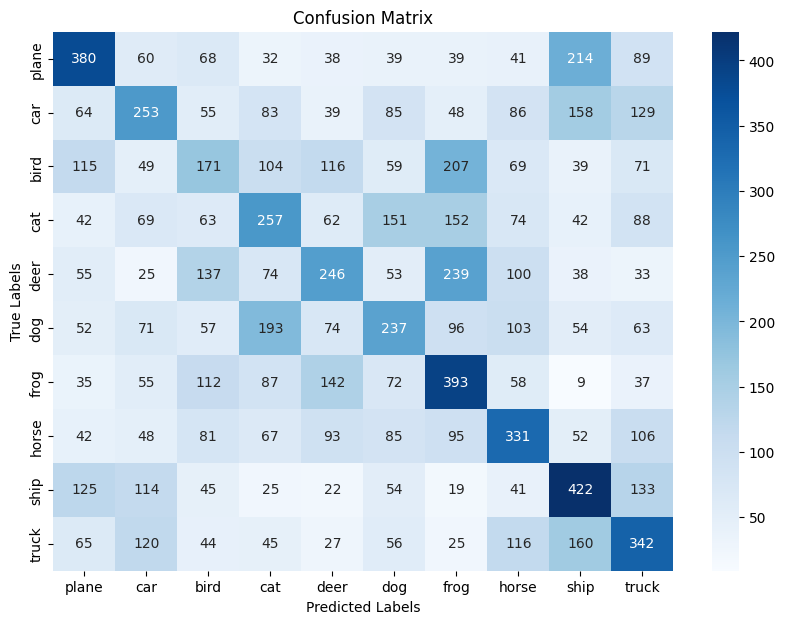

In [104]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Insights**
*  The model manages to classify vehicles much better than animals, maybe because of background colors and object size. For examle, most pictures of ships and planes will have a blue backgroud, with the vehicle centered in the frame.
*  When it comes to animals, the model finds it hardest to distinguish between cats and dogs, probably due to similar body shape and low picture resolution.


### Classification report

We'l look at the recall and precission of the model, regarding each class seperately. REMINDER:
$$\text{Recall}=\frac{TP}{TP+FN}$$

$$\text{Precision}=\frac{TP}{TP+FP}$$

$$\text{F1}=\frac{2\cdot\text{Recall}\cdot\text{Precision}}{\text{Recall}+\text{Precision}}$$


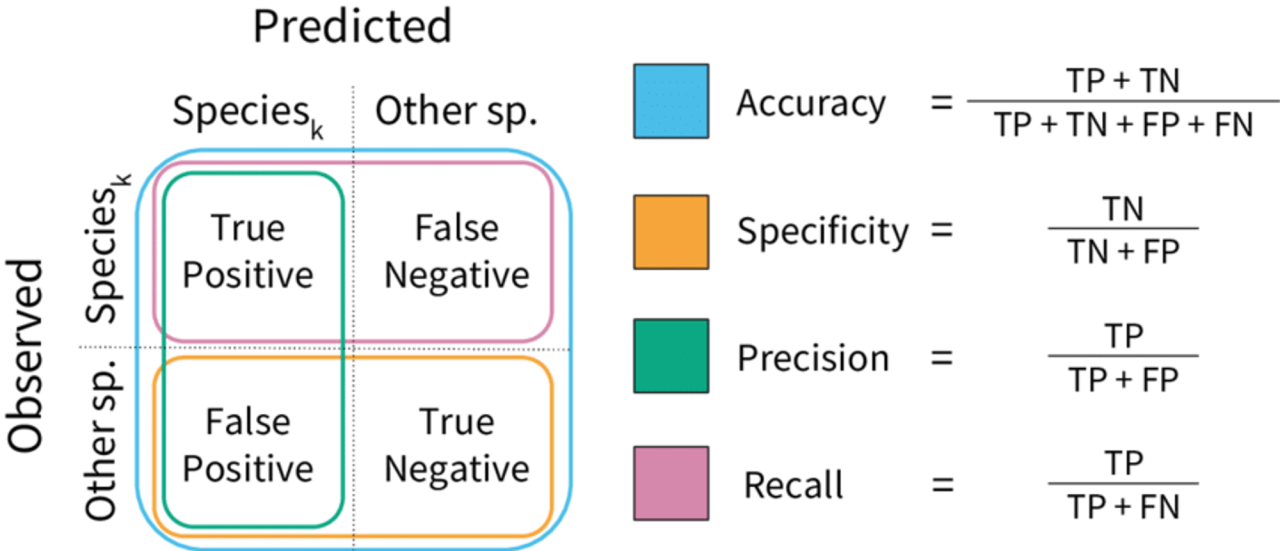

In [105]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

precision  recall  f1-score     support
0              0.389744  0.3800  0.384810   1000.0000
1              0.292824  0.2530  0.271459   1000.0000
2              0.205282  0.1710  0.186579   1000.0000
3              0.265770  0.2570  0.261312   1000.0000
4              0.286380  0.2460  0.264658   1000.0000
5              0.265993  0.2370  0.250661   1000.0000
6              0.299315  0.3930  0.339818   1000.0000
7              0.324828  0.3310  0.327885   1000.0000
8              0.355219  0.4220  0.385740   1000.0000
9              0.313474  0.3420  0.327116   1000.0000
accuracy       0.303200  0.3032  0.303200      0.3032
macro avg      0.299883  0.3032  0.300004  10000.0000
weighted avg   0.299883  0.3032  0.300004  10000.0000

### Where is the model wrong?

We may also look at examples where the model got it right, and examples where it got it wrong.

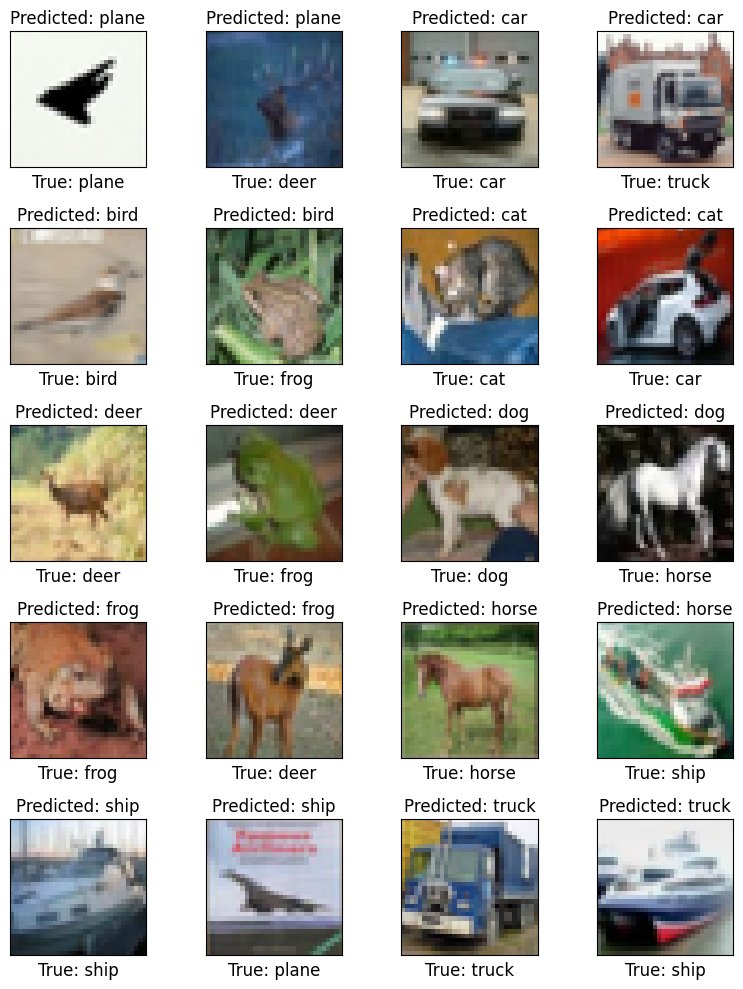

In [106]:
fig  = plt.figure(figsize=(8,10))
for i, class_name in enumerate(classes):

  # Define sets
  true_positive_images = x_test[(y_test == i) & (y_pred == i)]
  false_positive_images = x_test[(y_test != i) & (y_pred == i)]
  false_positive_labels = y_test[(y_test != i) & (y_pred == i)]

  # Correct classification
  plt.subplot(5,4,2*i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(true_positive_images[0])
  plt.title(f"Predicted: {class_name}")
  plt.xlabel(f"True: {class_name}", fontsize="12")

  # Incorrect classification
  plt.subplot(5,4,2*i+2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(false_positive_images[0])
  plt.title(f"Predicted: {class_name}")
  plt.xlabel(f"True: {classes[false_positive_labels[0]]}", fontsize="12")

plt.tight_layout()
plt.show()



We can see that the model performs poorly, but sometimes its errors are excusable, since the image it got wrong does resemple the predicted class.

### ROC curves

In [108]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

def plot_roc_curve_OvR(y_true, y_proba, class_of_interest, color, ax=None, plot_chance_level=False):

    # Use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion
    label_binarizer = LabelBinarizer()
    y_true_onehot = label_binarizer.fit_transform(y_true)

    # display ROC curve
    if ax is None:
      fig, ax = plt.subplots(figsize=(6, 6))

    display = RocCurveDisplay.from_predictions(
    y_true_onehot[:, classes.index(class_of_interest)],
    y_proba[:, classes.index(class_of_interest)],
    name=f"{class_of_interest} vs the rest",
    color=color,
    ax=ax,
    plot_chance_level=plot_chance_level)
    _ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"One-vs-Rest ROC curves:\n{class_of_interest} vs the rest")

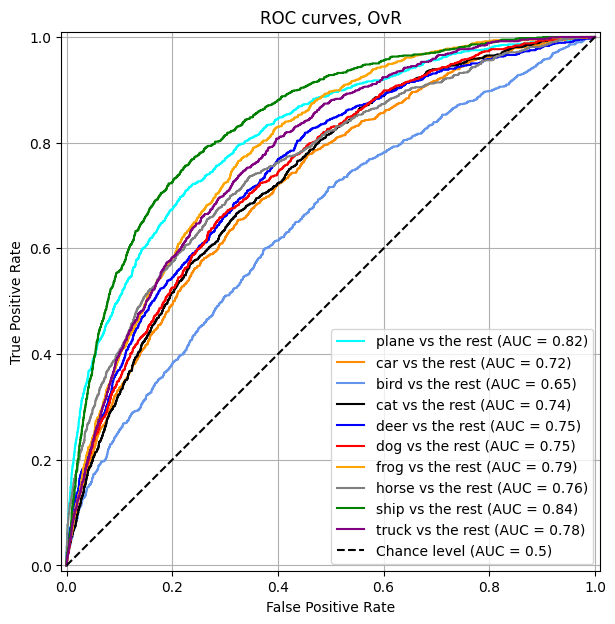

In [98]:
from itertools import cycle

n_classes = len(classes)
fig, ax = plt.subplots(figsize=(7, 7))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "black", "blue", "red", "orange", "gray", "green", "purple"])
for class_of_interest, color in zip(classes, colors):

    if (classes.index(class_of_interest) == n_classes-1):
      plot_roc_curve_OvR(y_test, y_proba, class_of_interest, color, ax, True)
    else:
      plot_roc_curve_OvR(y_test, y_proba, class_of_interest, color, ax, False)

ax.grid(True)
_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves, OvR",
)

## CNN approach

A CNN, which stands for **C**onvolutional **N**eural **N**etwork, is a family of models which combine neural networks with matrix convolutions. CNNs are usually used when dealing with images, in tasks like image classification, object detection, etc.

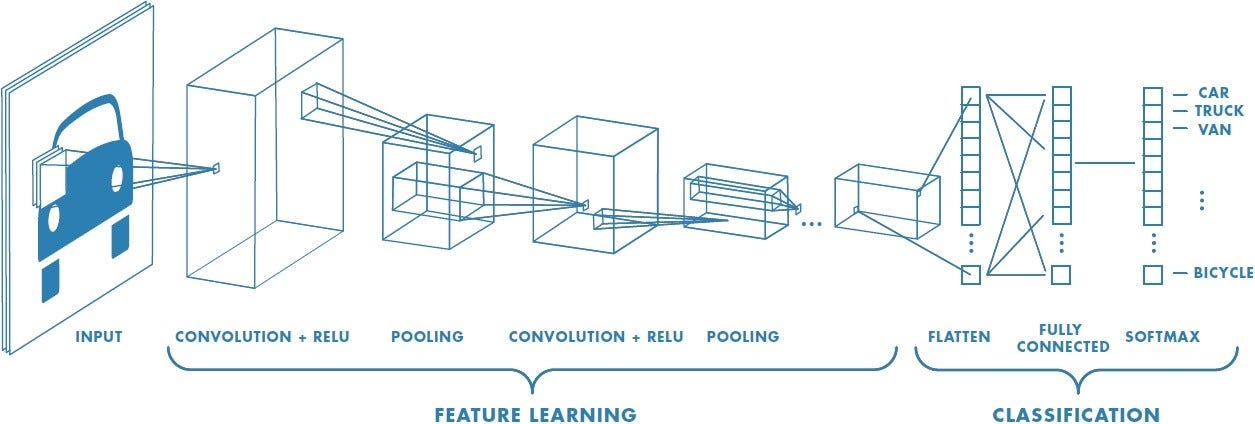

In [110]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import visualkeras

### Prepare Dataset

The NN will output a probabilty distribution on the 10 classes, so the labels must be one-hot encoded.

In [111]:
from tensorflow.keras.utils import to_categorical

# Normalize the images
x_train_nn = x_train / 255
x_test_nn = x_test / 255

# Convert class vectors to one-hot encoded labels
y_train_nn = to_categorical(y_train, 10)
y_test_nn = to_categorical(y_test, 10)


### Version 1

A basic CNN, which includes 2 convolution layers, each of them followed by a max pooling layer. Then the output is flattened and pased through a one-layer feed-forward network.

In [112]:
class CNNv1(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, (3,3), activation='relu')
        self.pool1 = MaxPooling2D(pool_size = (2,2))
        self.dropout1 = Dropout(0.25)
        self.conv2 = Conv2D(32,(3,3),activation='relu')
        self.pool2 = MaxPooling2D(pool_size = (2,2))
        self.dropout2 = Dropout(0.25)
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation ='relu')
        self.dropout3 = Dropout(0.5)
        self.dense2 = Dense(10, activation ='softmax')


    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout3(x)
        return self.dense2(x)

    def predict_proba(self, inputs, batch_size=1000):
        n_samples = inputs.shape[0]
        y_proba = np.zeros((n_samples, 10))
        for i in range(0, n_samples, batch_size):
          x_batch = inputs[i:i+batch_size]
          y_proba[i:i+batch_size] = self.call(x_batch)

        return y_proba

    def summary(self):
        inputs = tf.keras.Input(shape=(32, 32, 3))
        outputs = self.call(inputs)
        Model(inputs=inputs, outputs=outputs, name="CNN v1").summary()

In [118]:
modelv1 = CNNv1()
modelv1.summary()

Model: "CNN v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,018 (621.16 KB)

 Trainable params: 159,018 (621.16 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Architecture
We can also visualize the model:

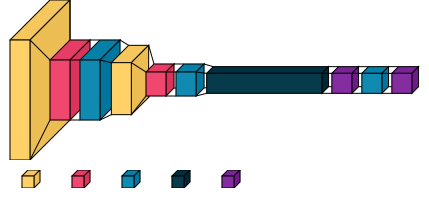

In [220]:
visualkeras.layered_view(modelv1, legend=True)

#### Custom Training Function

We'll use a custon training function, as we would like to save the loss and accuracy after every epoch.

In [119]:
import time
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

def train_model(model, X, y, loss_fn, optimizer, epochs, batch_size, early_stopping=False, delta=0):
  print("Training model...")

  # Storing accuracy and loss
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  # Training loop
  for epoch in range(epochs):
    # Print the current epoch
    print(f'Epoch {epoch+1}/{epochs}')
    start_time = time.time()

    # Shuffle the training data and split to training and validation sets
    n_samples = X.shape[0]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

    train_size = X_train.shape[0]


    # Split the training data into batches
    num_batches = train_size // batch_size

    # Loop over batches
    train_loss = 0
    train_predictions = []
    for i in tqdm(range(0, train_size, batch_size)):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(x_batch)
            loss = loss_fn(y_batch, predictions)
            train_loss += loss.numpy()
            train_predictions.append(predictions)


        # Backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Calculate training loss in batches
    train_loss /= num_batches # Average the loss
    train_losses.append(train_loss)

    # Calculate training accuracy in batches
    train_predictions = np.concatenate(train_predictions, axis=0)
    train_accuracy = np.mean(np.argmax(train_predictions, axis=1) == np.argmax(y_train, axis=1))
    train_accuracies.append(train_accuracy)

    # Calculate validation loss and accuracy
    val_predictions = model.predict_proba(X_val)
    val_loss = loss_fn(y_val, val_predictions).numpy()
    val_losses.append(val_loss)

    val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(y_val, axis=1))
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = int(end_time - start_time)
    elapsed_minutes = elapsed_time // 60
    elapsed_seconds = elapsed_time % 60

    print(f"Train loss: {train_loss:.2f}, Train accuracy: {train_accuracy*100:.2f}%")
    print(f"Validation loss: {val_loss:.2f}, Validation accuracy: {val_accuracy*100:.2f}%")
    print(f"Training time: {elapsed_minutes}m{elapsed_seconds}s")

    if early_stopping:
      if epoch > 1 and val_losses[-2] - val_losses[-1] < delta and val_losses[-3] - val_losses[-2] < delta:
        print("Early stopping triggered.")
        break

  print("Training complete.")

  return train_losses, val_losses, train_accuracies, val_accuracies

#### Train Model
We'll use the custom training function to train the model.

In [120]:
# Loss function and optimizer
lr = 1e-3
batch_size = 32
epochs = 20
loss_fn = CategoricalCrossentropy()
optimizer = Adam(learning_rate=lr)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(modelv1, x_train_nn, y_train_nn, loss_fn, optimizer, epochs, batch_size, early_stopping=True)

Training model...
Epoch 1/20


  0%|          | 0/1250 [00:00<?, ?it/s]

Train loss: 1.49, Train accuracy: 46.04%
Validation loss: 1.26, Validation accuracy: 54.71%
Training time: 1m43s
Epoch 2/20


  0%|          | 0/1250 [00:00<?, ?it/s]

Train loss: 1.17, Train accuracy: 58.74%
Validation loss: 1.11, Validation accuracy: 60.87%
Training time: 1m43s
Epoch 3/20


  0%|          | 0/1250 [00:00<?, ?it/s]

Train loss: 1.03, Train accuracy: 64.07%
Validation loss: 1.05, Validation accuracy: 62.65%
Training time: 1m44s
Epoch 4/20


  0%|          | 0/1250 [00:00<?, ?it/s]

Train loss: 0.93, Train accuracy: 67.58%
Validation loss: 1.03, Validation accuracy: 64.38%
Training time: 1m41s
Epoch 5/20


  0%|          | 0/1250 [00:00<?, ?it/s]

Train loss: 0.86, Train accuracy: 70.10%
Validation loss: 1.01, Validation accuracy: 65.28%
Training time: 1m42s
Epoch 6/20


  0%|          | 0/1250 [00:00<?, ?it/s]

Train loss: 0.79, Train accuracy: 72.47%
Validation loss: 1.02, Validation accuracy: 65.67%
Training time: 1m43s
Epoch 7/20


  0%|          | 0/1250 [00:00<?, ?it/s]

Train loss: 0.73, Train accuracy: 74.98%
Validation loss: 1.04, Validation accuracy: 65.60%
Training time: 1m43s
Early stopping triggered.
Training complete.


#### Save Model

We'll save the model:

In [121]:
modelv1.save("cnn_models\modelv1.keras")

#### Plot the Results

In [122]:
def plot_train_vs_val(train_losses, val_losses, train_accuracies, val_accuracies):
  plt.figure(figsize=(10, 5))
  epochs = range(1, len(train_losses) + 1)
  # Plot training and validation loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label='Training Loss')
  plt.plot(epochs, val_losses, label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plot training and validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accuracies, label='Training Accuracy')
  plt.plot(epochs, val_accuracies, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()


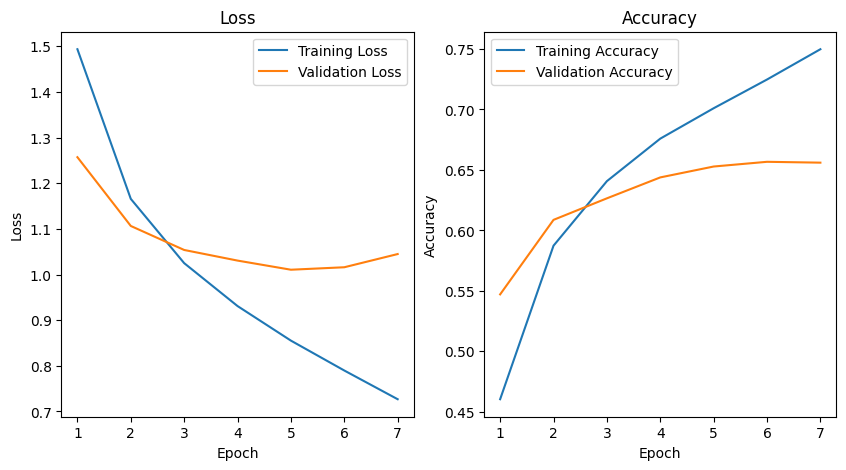

In [123]:
plot_train_vs_val(train_losses, val_losses, train_accuracies, val_accuracies)

We can see that the model started overfitting, which is why we stopped it.

#### Model evaluation

In [193]:
y_proba = modelv1.predict_proba(x_test_nn)
y_pred = np.argmax(y_proba, axis=1)

##### Confusion matrix

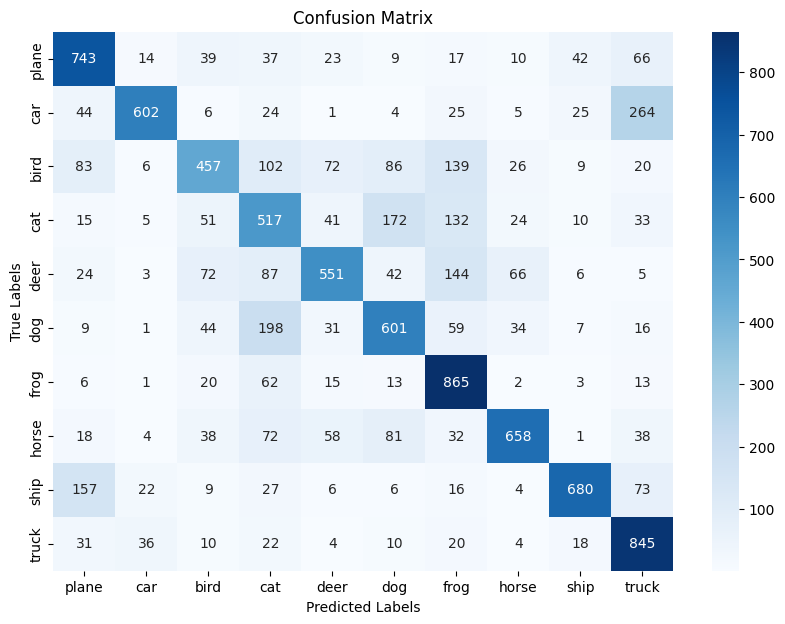

In [125]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Insights**
*  We can see that the model performs pretty well, especially on vehicles.
*  Most of its misclassifications are understandable:
  - It confuses cat most with dog.
  - it confuses car most with truck.
  - it confuses ship most with plane.


##### Classification report

We'l look at the recall and precission of the model, regarding each class seperately.

In [126]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

precision  recall  f1-score     support
0              0.657522  0.7430  0.697653   1000.0000
1              0.867435  0.6020  0.710744   1000.0000
2              0.612601  0.4570  0.523482   1000.0000
3              0.450348  0.5170  0.481378   1000.0000
4              0.687032  0.5510  0.611543   1000.0000
5              0.586914  0.6010  0.593874   1000.0000
6              0.596963  0.8650  0.706411   1000.0000
7              0.789916  0.6580  0.717949   1000.0000
8              0.848939  0.6800  0.755136   1000.0000
9              0.615441  0.8450  0.712179   1000.0000
accuracy       0.651900  0.6519  0.651900      0.6519
macro avg      0.671311  0.6519  0.651035  10000.0000
weighted avg   0.671311  0.6519  0.651035  10000.0000

Accuracy of `65.19%`! much better than before.

##### Where is the model wrong?

We may also look at examples where the model got it right, and examples where it got it wrong.

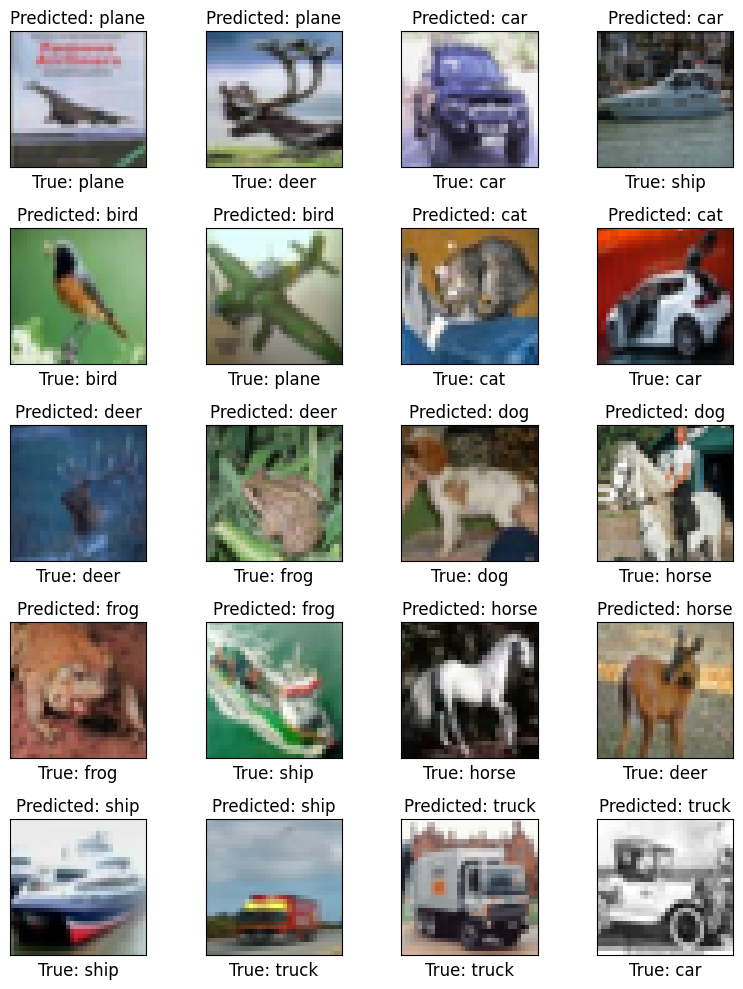

In [127]:
fig  = plt.figure(figsize=(8,10))
for i, class_name in enumerate(classes):
  # Define sets
  true_positive_images = x_test[(y_test == i) & (y_pred == i)]
  false_positive_images = x_test[(y_test != i) & (y_pred == i)]
  false_positive_labels = y_test[(y_test != i) & (y_pred == i)]

  # Correct classification
  plt.subplot(5,4,2*i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(true_positive_images[0])
  plt.title(f"Predicted: {class_name}")
  plt.xlabel(f"True: {class_name}", fontsize="12")

  # Incorrect classification
  plt.subplot(5,4,2*i+2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(false_positive_images[0])
  plt.title(f"Predicted: {class_name}")
  plt.xlabel(f"True: {classes[false_positive_labels[0]]}", fontsize="12")

plt.tight_layout()
plt.show()



Most of these misclassifications are explainable and not random. For example, truck and car are in fact similar classes.

##### ROC curves

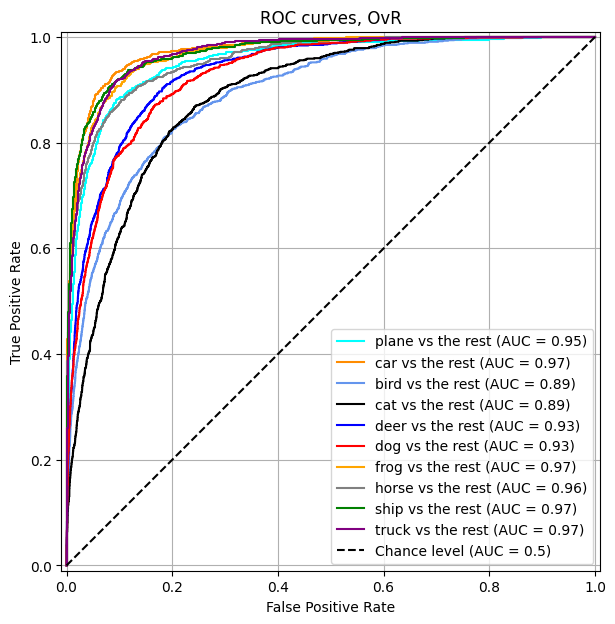

In [128]:
from itertools import cycle

n_classes = len(classes)
fig, ax = plt.subplots(figsize=(7, 7))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "black", "blue", "red", "orange", "gray", "green", "purple"])
for class_of_interest, color in zip(classes, colors):

    if (classes.index(class_of_interest) == n_classes-1):
      plot_roc_curve_OvR(y_test, y_proba, class_of_interest, color, ax, True)
    else:
      plot_roc_curve_OvR(y_test, y_proba, class_of_interest, color, ax, False)

ax.grid(True)
_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves, OvR",
)

### Version 2

In this version, we add more convolution layers, as well as changing the dropout to be more gradual.

In [129]:
class CNNv2(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, (3,3), activation='relu', padding='same')
        self.conv2 = Conv2D(32, (3,3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D(pool_size=(2,2))
        self.dropout1 = Dropout(0.2)
        self.conv3 = Conv2D(64, (3,3), activation='relu', padding='same')
        self.conv4 = Conv2D(64, (3,3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D(pool_size=(2,2))
        self.dropout2 = Dropout(0.3)
        self.conv5 = Conv2D(128, (3,3), activation='relu', padding='same')
        self.conv6 = Conv2D(128, (3,3), activation='relu', padding='same')
        self.pool3 = MaxPooling2D(pool_size=(2,2))
        self.dropout3 = Dropout(0.4)
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation ='relu')
        self.dropout4 = Dropout(0.5)
        self.dense2 = Dense(10, activation ='softmax')


    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout4(x)
        return self.dense2(x)

    def predict_proba(self, inputs, batch_size=1000):
        n_samples = inputs.shape[0]
        y_proba = np.zeros((n_samples, 10))
        for i in range(0, n_samples, batch_size):
          x_batch = inputs[i:i+batch_size]
          y_proba[i:i+batch_size] = self.call(x_batch)

        return y_proba

    def summary(self):
        inputs = tf.keras.Input(shape=(32, 32, 3))
        outputs = self.call(inputs)
        Model(inputs=inputs, outputs=outputs, name="CNN v2").summary()

In [141]:
modelv2 = CNNv2()
modelv2.summary()

Model: "CNN v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

#### Model Architecture

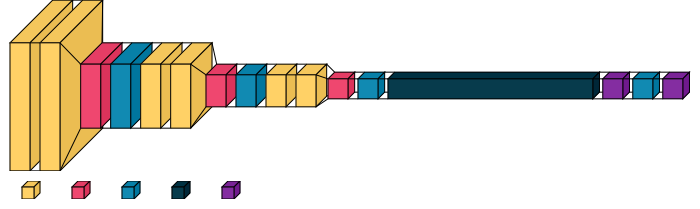

In [142]:
visualkeras.layered_view(modelv2, legend=True)

#### Train model
Since this model is larger, we'll use the default keras `model.fit()` function, which is much faster. It also allows us to implement **early stopping**.

In [143]:
from tensorflow.keras.callbacks import EarlyStopping

# Loss function and optimizer
lr = 1e-3
patience = 5
batch_size = 32
epochs = 50
loss_fn = CategoricalCrossentropy()
optimizer = Adam(learning_rate=lr)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Train the model
modelv2.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
x_train_nn_new, x_val_nn, y_train_nn_new, y_val_nn = train_test_split(x_train_nn, y_train_nn, test_size = 0.1, stratify = y_train_nn, random_state = seed)
historyv2 = modelv2.fit(x_train_nn_new, y_train_nn_new, batch_size=batch_size, epochs=epochs, validation_data=(x_val_nn, y_val_nn), callbacks=[early_stopping])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 74s 51ms/step - accuracy: 0.3101 - loss: 1.8362 - val_accuracy: 0.5858 - val_loss: 1.1588
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 67s 48ms/step - accuracy: 0.6191 - loss: 1.0732 - val_accuracy: 0.6480 - val_loss: 1.0192
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.6966 - loss: 0.8582 - val_accuracy: 0.6940 - val_loss: 0.8836
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 69s 49ms/step - accuracy: 0.7502 - loss: 0.7076 - val_accuracy: 0.7320 - val_loss: 0.7628
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 71s 50ms/step - accuracy: 0.7889 - loss: 0.5990 - val_accuracy: 0.7324 - val_loss: 0.7846
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - accuracy: 0.8238 - loss: 0.4954 - val_accuracy: 0.7266 - val_loss: 0.8456
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 0.8541 - loss: 0.4168 - val_accuracy: 0.7410 - val_loss: 0.8297
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step - accuracy: 0.8723 -

#### Save Model

In [144]:
modelv2.save("cnn_models\modelv2.keras")

#### Plot the Results

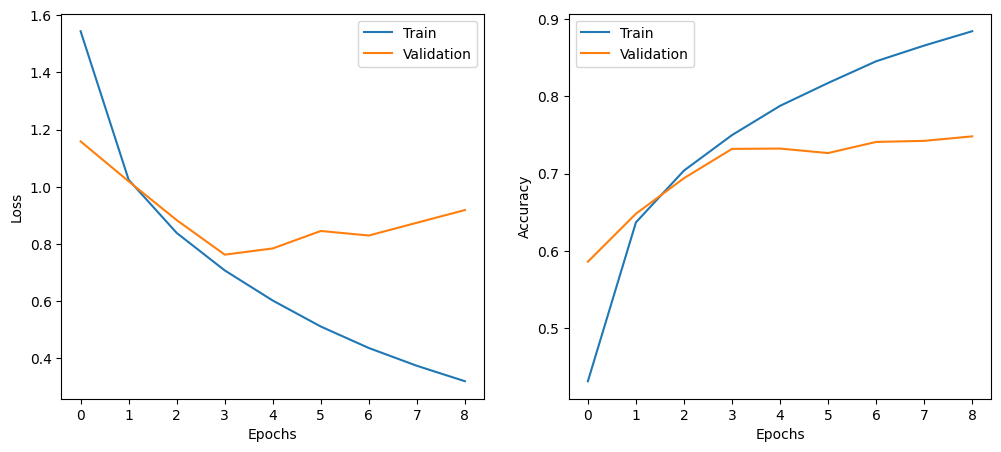

In [145]:
def plotresults(history):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    # Accuracy
    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    
    plt.show()

plotresults(historyv2)

The model started overfitting, which is why it stopped training.

#### Model Evaluation

##### Confusion Matrix

In [146]:
y_proba = modelv2.predict_proba(x_test_nn)
y_pred = np.argmax(y_proba, axis=1)

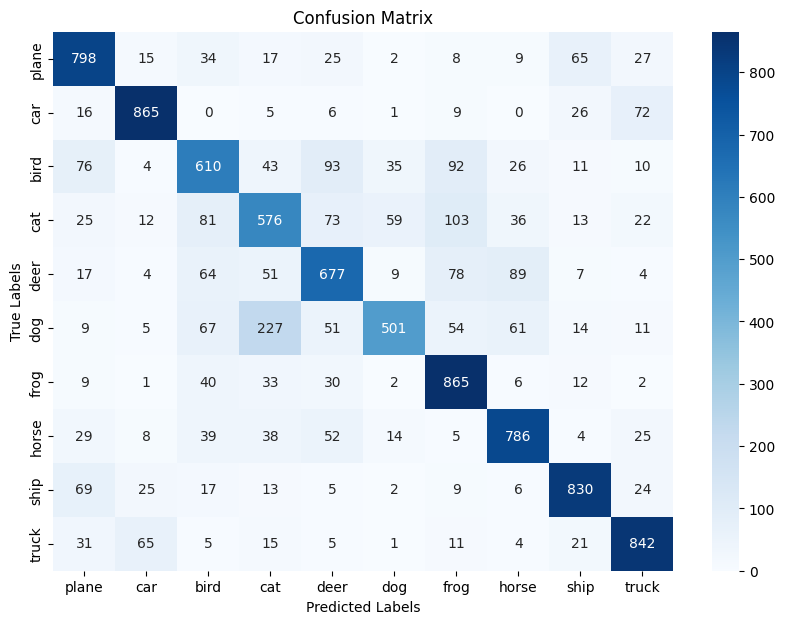

In [147]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Insights**

*  We can see that the model performs pretty well again, especially on vehicles.

* Very similar to Version 1, with slight improvments across all the categories.

*  Most of its misclassifications are understandable:
  - It confuses cat most with dog.
  - it confuses car most with truck.
  - it confuses ship most with plane.

##### Classification report

We'l look at the recall and precission of the model, regarding each class seperately. 


In [148]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

precision  recall  f1-score    support
0              0.739574   0.798  0.767677   1000.000
1              0.861554   0.865  0.863273   1000.000
2              0.637409   0.610  0.623403   1000.000
3              0.565815   0.576  0.570862   1000.000
4              0.665683   0.677  0.671294   1000.000
5              0.800319   0.501  0.616236   1000.000
6              0.700972   0.865  0.774396   1000.000
7              0.768328   0.786  0.777064   1000.000
8              0.827517   0.830  0.828757   1000.000
9              0.810395   0.842  0.825895   1000.000
accuracy       0.735000   0.735  0.735000      0.735
macro avg      0.737757   0.735  0.731886  10000.000
weighted avg   0.737757   0.735  0.731886  10000.000

Accuracy of `73.5%`, an improvement over version 1 by `8.3%`.

##### Where is the model wrong?

We may also look at examples where the model got it right, and examples where it got it wrong.

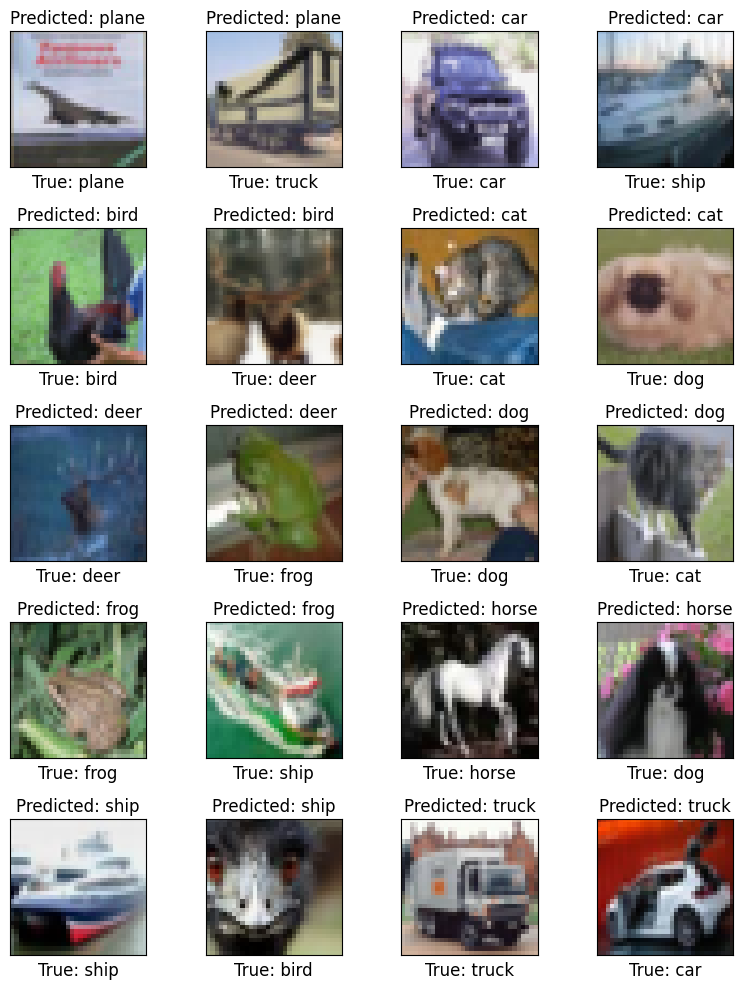

In [149]:
fig  = plt.figure(figsize=(8,10))
for i, class_name in enumerate(classes):
  # Define sets
  true_positive_images = x_test[(y_test == i) & (y_pred == i)]
  false_positive_images = x_test[(y_test != i) & (y_pred == i)]
  false_positive_labels = y_test[(y_test != i) & (y_pred == i)]

  # Correct classification
  plt.subplot(5,4,2*i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(true_positive_images[0])
  plt.title(f"Predicted: {class_name}")
  plt.xlabel(f"True: {class_name}", fontsize="12")

  # Incorrect classification
  plt.subplot(5,4,2*i+2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(false_positive_images[0])
  plt.title(f"Predicted: {class_name}")
  plt.xlabel(f"True: {classes[false_positive_labels[0]]}", fontsize="12")

plt.tight_layout()
plt.show()



##### ROC curves

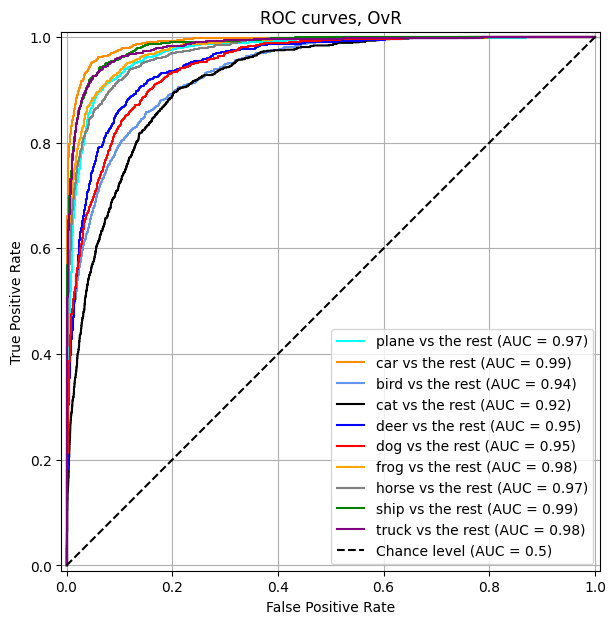

In [150]:
from itertools import cycle

n_classes = len(classes)
fig, ax = plt.subplots(figsize=(7, 7))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "black", "blue", "red", "orange", "gray", "green", "purple"])
for class_of_interest, color in zip(classes, colors):

    if (classes.index(class_of_interest) == n_classes-1):
      plot_roc_curve_OvR(y_test, y_proba, class_of_interest, color, ax, True)
    else:
      plot_roc_curve_OvR(y_test, y_proba, class_of_interest, color, ax, False)

ax.grid(True)
_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves, OvR",
)

### Version 3

In this version, we added `BatchNormalization` after each layer, to reduce overfitting and make the training easier and more efficient.

In [151]:
class CNNv3(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, (3,3), activation='relu', padding='same')
        self.batchnorm1 = BatchNormalization()
        self.conv2 = Conv2D(32, (3,3), activation='relu', padding='same')
        self.batchnorm2 = BatchNormalization()
        self.pool1 = MaxPooling2D(pool_size=(2,2))
        self.dropout1 = Dropout(0.2)
        self.conv3 = Conv2D(64, (3,3), activation='relu', padding='same')
        self.batchnorm3 = BatchNormalization()
        self.conv4 = Conv2D(64, (3,3), activation='relu', padding='same')
        self.batchnorm4 = BatchNormalization()
        self.pool2 = MaxPooling2D(pool_size=(2,2))
        self.dropout2 = Dropout(0.3)
        self.conv5 = Conv2D(128, (3,3), activation='relu', padding='same')
        self.batchnorm5 = BatchNormalization()
        self.conv6 = Conv2D(128, (3,3), activation='relu', padding='same')
        self.batchnorm6 = BatchNormalization()
        self.pool3 = MaxPooling2D(pool_size=(2,2))
        self.dropout3 = Dropout(0.4)
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation ='relu')
        self.batchnorm7 = BatchNormalization()
        self.dropout4 = Dropout(0.5)
        self.dense2 = Dense(10, activation ='softmax')


    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = self.conv6(x)
        x = self.batchnorm6(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.batchnorm7(x)
        x = self.dropout4(x)
        return self.dense2(x)

    def predict_proba(self, inputs, batch_size=1000):
        n_samples = inputs.shape[0]
        y_proba = np.zeros((n_samples, 10))
        for i in range(0, n_samples, batch_size):
          x_batch = inputs[i:i+batch_size]
          y_proba[i:i+batch_size] = self.call(x_batch)

        return y_proba

    def summary(self):
        inputs = tf.keras.Input(shape=(32, 32, 3))
        outputs = self.call(inputs)
        Model(inputs=inputs, outputs=outputs, name="CNN v3").summary()

In [162]:
modelv3 = CNNv3()
modelv3.summary()

Model: "CNN v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

#### Model Architecture

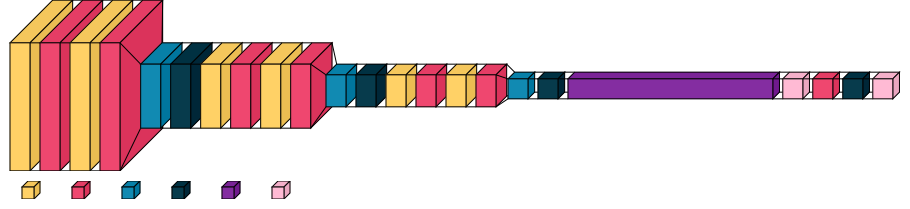

In [216]:
visualkeras.layered_view(modelv3, legend=True)

#### Train model

This time, we'll use data augmentation to reduce overfitting.

**Data Augmentation** - the addition of new data artificially derived from existing training data. Techniques include resizing, flipping, rotating, cropping, padding, etc. It helps to address issues like overfitting and data scarcity.

In [164]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def get_train_iterator(x_train, y_train, batch_size):
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  it_train = datagen.flow(x_train, y_train, batch_size=batch_size)
  return it_train

In [165]:
from tensorflow.keras.callbacks import EarlyStopping
# Loss function and optimizer
lr = 1e-3
patience = 25
batch_size = 64
epochs = 100
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Train the model

# Compile
modelv3.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Create validation set
x_train_nn_new, x_val_nn, y_train_nn_new, y_val_nn = train_test_split(x_train_nn, y_train_nn, test_size=0.1, stratify=y_train_nn, random_state=seed)
it_train = get_train_iterator(x_train_nn_new, y_train_nn_new, batch_size)
steps = int(x_train_nn_new.shape[0] / batch_size)
historyv3 = modelv3.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(x_val_nn, y_val_nn), callbacks=[early_stopping])

Epoch 1/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 93s 123ms/step - accuracy: 0.3170 - loss: 1.8287 - val_accuracy: 0.5722 - val_loss: 1.1874
Epoch 2/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6719 - loss: 0.9516 - val_accuracy: 0.5732 - val_loss: 1.1929
Epoch 3/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 87s 123ms/step - accuracy: 0.6054 - loss: 1.1048 - val_accuracy: 0.6920 - val_loss: 0.8887
Epoch 4/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5625 - loss: 1.2606 - val_accuracy: 0.6796 - val_loss: 0.9233
Epoch 5/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 86s 122ms/step - accuracy: 0.6993 - loss: 0.8643 - val_accuracy: 0.7328 - val_loss: 0.7625
Epoch 6/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8281 - loss: 0.5992 - val_accuracy: 0.7314 - val_loss: 0.7753
Epoch 7/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 88s 124ms/step - accuracy: 0.7425 - loss: 0.7353 - val_accuracy: 0.7628 - val_loss: 0.6848
Epoch 8/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8281 - loss: 0.464

#### Save Model

In [213]:
modelv3.save("cnn_models\modelv3.keras")

#### Plot the Results

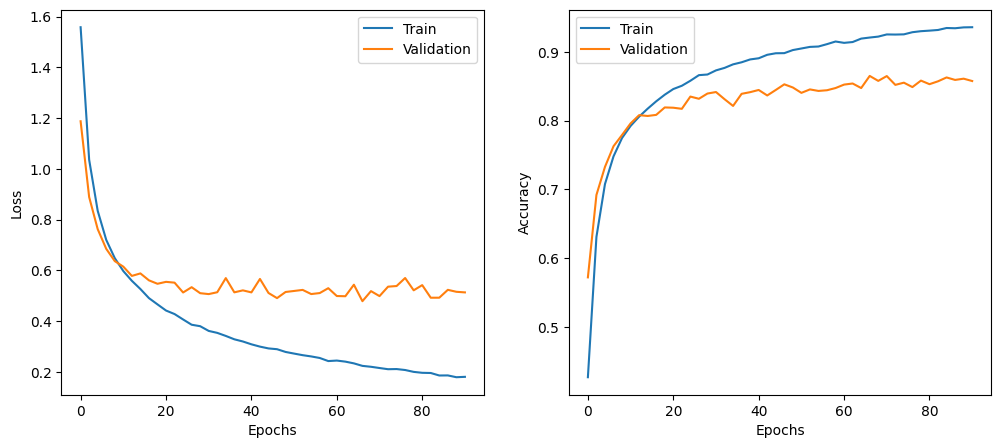

In [173]:
def plotresults(history):
    plt.figure(figsize=(12,5))
    epochs = len(history.history['loss'])
    x = range(0, epochs, 2)
    # Loss
    plt.subplot(1,2,1)
    
    plt.plot(x, history.history['loss'][::2])
    plt.plot(x, history.history['val_loss'][::2])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(x, history.history['accuracy'][::2])
    plt.plot(x, history.history['val_accuracy'][::2])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    
    plt.show()

plotresults(historyv3)

This time, the model seemed less prone to overfitting, as validation loss kept decreasing.

#### Model Evaluation

##### Confusion Matrix

In [167]:
y_proba = modelv3.predict_proba(x_test_nn)
y_pred = np.argmax(y_proba, axis=1)

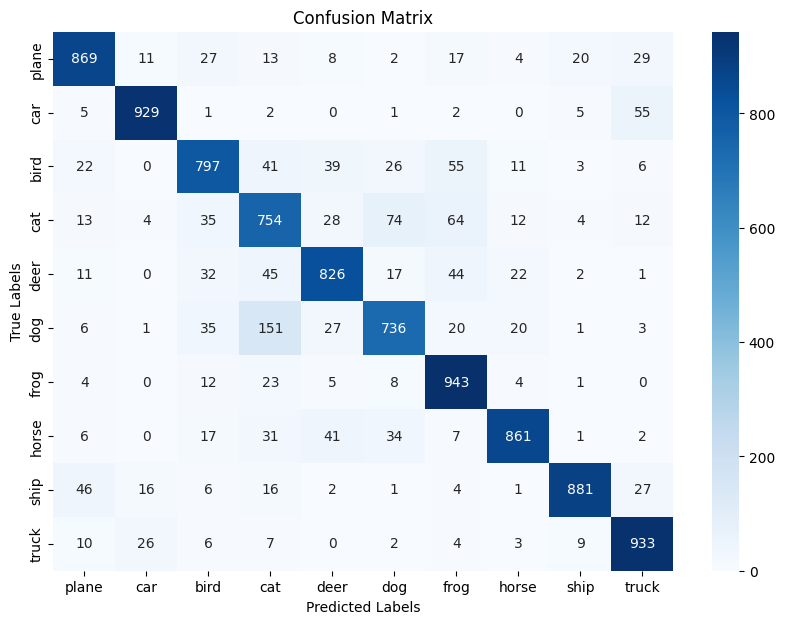

In [168]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Insights**

*  We can see that the model performs very well across all the classes.
*  Its biggest mistakes are among cats and dogs.


##### Classification report

We'l look at the recall and precission pf the model, regarding each class seperately. 


In [169]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

precision  recall  f1-score     support
0              0.876008  0.8690  0.872490   1000.0000
1              0.941236  0.9290  0.935078   1000.0000
2              0.823347  0.7970  0.809959   1000.0000
3              0.696214  0.7540  0.723956   1000.0000
4              0.846311  0.8260  0.836032   1000.0000
5              0.816870  0.7360  0.774329   1000.0000
6              0.812931  0.9430  0.873148   1000.0000
7              0.917910  0.8610  0.888545   1000.0000
8              0.950378  0.8810  0.914375   1000.0000
9              0.873596  0.9330  0.902321   1000.0000
accuracy       0.852900  0.8529  0.852900      0.8529
macro avg      0.855480  0.8529  0.853023  10000.0000
weighted avg   0.855480  0.8529  0.853023  10000.0000

Accuracy of `85.29%`, an improvement over version 2 by `11.8%`.

##### Where is the model wrong?

We may also look at examples where the model got it right, and examples where it got it wrong.

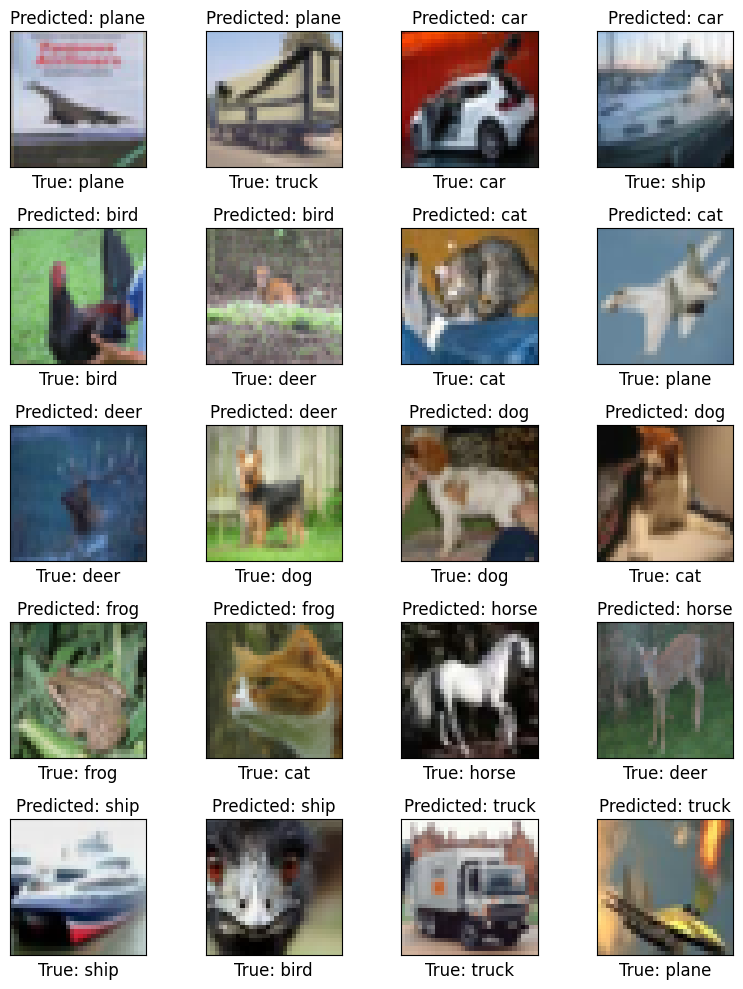

In [171]:
fig  = plt.figure(figsize=(8,10))
for i, class_name in enumerate(classes):
  # Define sets
  true_positive_images = x_test[(y_test == i) & (y_pred == i)]
  false_positive_images = x_test[(y_test != i) & (y_pred == i)]
  false_positive_labels = y_test[(y_test != i) & (y_pred == i)]

  # Correct classification
  plt.subplot(5,4,2*i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(true_positive_images[0])
  plt.title(f"Predicted: {class_name}")
  plt.xlabel(f"True: {class_name}", fontsize="12")

  # Incorrect classification
  plt.subplot(5,4,2*i+2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(false_positive_images[0])
  plt.title(f"Predicted: {class_name}")
  plt.xlabel(f"True: {classes[false_positive_labels[0]]}", fontsize="12")

plt.tight_layout()
plt.show()



##### ROC curves

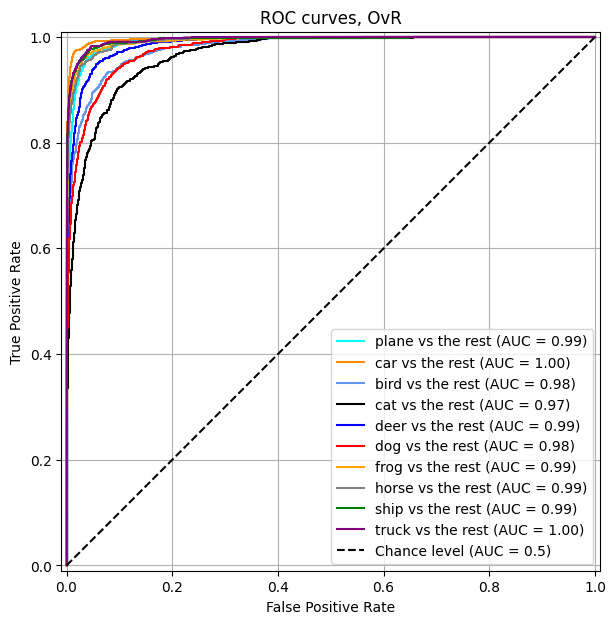

In [170]:
from itertools import cycle

n_classes = len(classes)
fig, ax = plt.subplots(figsize=(7, 7))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "black", "blue", "red", "orange", "gray", "green", "purple"])
for class_of_interest, color in zip(classes, colors):

    if (classes.index(class_of_interest) == n_classes-1):
      plot_roc_curve_OvR(y_test, y_proba, class_of_interest, color, ax, True)
    else:
      plot_roc_curve_OvR(y_test, y_proba, class_of_interest, color, ax, False)

ax.grid(True)
_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves, OvR",
)